<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-END-Program/blob/main/10-%20HandsOn%204/RNN_attention_based_machine_translation_with_packed_padded_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 1.2MB 22.3MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Extension of Flickr30K dataset. Contains German trnaslations of English descriptions.
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import time
import math

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Download and load spacy models for DE and EN.

In [4]:
# Download and load spacy models for DE and EN languages. To be used for tokenization.
%%bash
python -m spacy download en
python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=bd6d6ef7fc5fc0307628070a323579f1db34387b0608127c9e816b0ec014bb83
  Stored in directory: /tmp/pip-ephem-wheel-cache-lwjcz2g2/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [5]:
# After linking spacy.load('de_core_news_sm') -> spacy.load('de')
spacy_de = spacy.load('de')
# After linking spacy.load('en_core_web_sm') -> spacy.load('en')
spacy_en = spacy.load('en')

### Prepare tokenizers

Takes in string and returns list of tokens. Will be passed to torchtext.

In [6]:
# Tokenizer for German. 
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

### Prepare FIELDS

Defines a datatype together with instructions for converting to Tensor. holds a Vocab object that defines the set of possible values
    for elements of the field and their corresponding numerical representations.
This time include_lengths is added which tells how long the sequences are. With include_lengths, batch.src is a tuple. The first element is the indexed source sentence and second element is the length of the source sentence.
SRC is English and TRG is German.

In [7]:
SRC = Field(tokenize = tokenize_en, init_token = '<SOS>', eos_token = '<EOS>', include_lengths = True, lower = True)
TRG = Field(tokenize = tokenize_de, init_token = '<SOS>', eos_token = '<EOS>', lower = True)

In [8]:
SRC.__dict__

{'batch_first': False,
 'dtype': torch.int64,
 'eos_token': '<EOS>',
 'fix_length': None,
 'include_lengths': True,
 'init_token': '<SOS>',
 'is_target': False,
 'lower': True,
 'pad_first': False,
 'pad_token': '<pad>',
 'postprocessing': None,
 'preprocessing': None,
 'sequential': True,
 'stop_words': None,
 'tokenize': <function __main__.tokenize_en>,
 'tokenizer_args': (<function __main__.tokenize_en>, 'en'),
 'truncate_first': False,
 'unk_token': '<unk>',
 'use_vocab': True}

### Download Multi30K dataset and load train, test and val data.

In [9]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.en', '.de'), fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 977kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 273kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 265kB/s]


In [10]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [11]:
print(vars(train_data.examples[0]))

{'src': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.'], 'trg': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']}


### Build vocabulary for SRC and TRG

Vocabulary will associate each unique tokens with an index. Only tokens that appear atleast 2 times are considered. Other such words are replaced by <UNK>. Vocab object built on only training examples.

In [12]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [13]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 5893
Unique tokens in target (en) vocabulary: 7855


In [14]:
# SRC.vocab dict has the following keys - freqs(provides word and its frequencies), itos(mapping of integer to string), 
# stoi(mapping of string to its integer) and vectors()
print(SRC.vocab.__dict__.keys())
SRC.vocab.__dict__

dict_keys(['freqs', 'itos', 'unk_index', 'stoi', 'vectors'])


{'freqs': Counter({'two': 3886,
          'young': 2280,
          ',': 3963,
          'white': 2238,
          'males': 40,
          'are': 3717,
          'outside': 871,
          'near': 571,
          'many': 222,
          'bushes': 19,
          '.': 27623,
          'several': 404,
          'men': 1759,
          'in': 14886,
          'hard': 123,
          'hats': 146,
          'operating': 22,
          'a': 49165,
          'giant': 45,
          'pulley': 3,
          'system': 6,
          'little': 916,
          'girl': 1723,
          'climbing': 193,
          'into': 711,
          'wooden': 175,
          'playhouse': 3,
          'man': 7781,
          'blue': 1880,
          'shirt': 2324,
          'is': 7525,
          'standing': 1614,
          'on': 8035,
          'ladder': 60,
          'cleaning': 60,
          'window': 183,
          'at': 2927,
          'the': 10955,
          'stove': 23,
          'preparing': 105,
          'food': 357,
        

### Create iterators for train, valid and test.

BucketIterator is used instead of Standard Iterator. BucketIterator defines an iterator that batches examples of similar lengths together.

Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch.

batch.src - [ (128) , (128), .. 23 times]**bold text**

In [15]:
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), 
                                                                      batch_size = BATCH_SIZE,
                                                                      sort_within_batch = True,
                                                                      sort_key = lambda x : len(x.src), 
                                                                      device = device)

device

device(type='cuda')

### Build model

#### Encoder

Bidirectional GRUs are being used to encode the source sequence.

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim*2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src, src_len):
        # src = [src_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src_len, batch_size, emb_dim]

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        packed_outputs, hidden = self.rnn(packed_embedded)
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)

        # outputs = [src_len, batch_size, num_direction * enc_hid_dim]
        # hidden = [num_layers*num_direction, batch_size, enc_hid_dim]
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        # hidden = [batch_size, dec_hid_dim]
        # outputs = [src_len, batch_size, num_direction * enc_hid_dim]
        return outputs, hidden

#### Attention

Mask is used to force the attention to only be over non-padding elements.

forward method now takes a mask input. This is a [batch size, source sentence length] tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", <pad>, <pad>], then the mask would be [1, 1, 1, 1, 1, 0, 0].

In [17]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim *2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask):
        # hidden - decoder hidden state- s(t-1) [batch_size, dec_hid_dim]
        # encoder_outputs = [src_len, batch_size, enc_hid_dim*2]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # hidden = [batch_size, dec_hid_dim] -> [batch_size, 1, dec_hid_dim] -> [batch_size, src_len, dec_hid_dim]
        # encoder_outputs = [src_len, batch_size, 2*enc_hid_dim] -> [batch_size, src_len, 2*enc_hid_dim]

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2 )))
        # energy = [batch_size, src_len, dec_hid_dim]
        attention = self.v(energy).squeeze(2)
        # attention = [batch_size, src_len]
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim=1)

#### Decoder

Decoder now accepts a mask over the source sentence and pass this to the attention module.

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.attention = attention
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(enc_hid_dim*2 + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear(enc_hid_dim*2 + emb_dim + dec_hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input, hidden, encoder_outputs, mask):
        # input = [batch_size]
        # hidden = [batch_size, dec_hid_dim]
        # encoder_outputs = [src_len, batch_size, 2*enc_hid_dim]
        # mask = [batch size, src len]

        input = input.unsqueeze(0)
        # input = [1, batch_size]

        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch_size, emb_dim]

        a = self.attention(hidden, encoder_outputs, mask)
        # a = [batch_size, src_len]
        a = a.unsqueeze(1)
        # a = [batch_size, 1, src_len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch_size, src_len, enc_hid_dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch_size, 1, enc_hid_dim*2]
        weighted = weighted.permute(1, 0, 2)        
        # weighted = [1, batch_size, enc_hid_dim * 2]

        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input = [1, batch_size, enc_hid_dim*2 + emb_dim]

        # hidden.unsqueeze(0) = [1, batch_size, dec_hid_dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [1, batch_size, dec_hid_dim]
        # hidden = [1, batch_size, dec_hid_dim]

        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, embedded, weighted), dim = 1))
        #prediction = [batch_size, output_dim]

        return prediction, hidden.squeeze(0), a.squeeze(1)


#### Seq2Seq model

Model's changes are for packed padded sequence and masking.

In [19]:
# build seq2seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
    
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask

    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        # src_len = [batch_size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # tensor to store decoder output
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Last hidden state of the encoder is the context
        encoder_outputs, hidden = self.encoder(src, src_len)

        # first input to the decoder is <sos> token
        input = trg[0,:]

        mask = self.create_mask(src)
        # mask = [batch_size, src_len]

        for t in range(1, trg_len):
            #insert input token embedding, previous hidden state, context state and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            # decide of teacher forcing is going to be used
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

### Training Seq2Seq model

In [20]:
INPUT_DIM = len(SRC.vocab) # 5893
OUTPUT_DIM = len(TRG.vocab) # 7855
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [21]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5893, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(7855, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=7855, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 24,036,783 trainable parameters


### Define optimizer and criterion

In [23]:
optimizer = optim.Adam(model.parameters())

In [24]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training loop

In [25]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src, src_len = batch.src
        # src_len needs to be on cpu - https://github.com/pytorch/pytorch/issues/43227
        src_len = src_len.cpu()
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
 
        #trg = [trg_len, batch_size]
        #output = [trg_len, batch_size, output_dim]

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src, src_len = batch.src
            # src_len needs to be on cpu - https://github.com/pytorch/pytorch/issues/43227
            src_len = src_len.cpu()
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
train_loss_all = []
valid_loss_all = []

In [29]:
N_EPOCHS = 25
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 52s
	Train Loss: 5.166 | Train PPL: 175.139
	 Val. Loss: 4.880 |  Val. PPL: 131.625
Epoch: 02 | Time: 0m 53s
	Train Loss: 4.107 | Train PPL:  60.775
	 Val. Loss: 4.144 |  Val. PPL:  63.085
Epoch: 03 | Time: 0m 56s
	Train Loss: 3.327 | Train PPL:  27.863
	 Val. Loss: 3.548 |  Val. PPL:  34.752
Epoch: 04 | Time: 0m 56s
	Train Loss: 2.762 | Train PPL:  15.837
	 Val. Loss: 3.264 |  Val. PPL:  26.162
Epoch: 05 | Time: 0m 55s
	Train Loss: 2.342 | Train PPL:  10.403
	 Val. Loss: 3.148 |  Val. PPL:  23.289
Epoch: 06 | Time: 0m 56s
	Train Loss: 2.004 | Train PPL:   7.418
	 Val. Loss: 3.123 |  Val. PPL:  22.704
Epoch: 07 | Time: 0m 56s
	Train Loss: 1.760 | Train PPL:   5.810
	 Val. Loss: 3.160 |  Val. PPL:  23.567
Epoch: 08 | Time: 0m 55s
	Train Loss: 1.586 | Train PPL:   4.882
	 Val. Loss: 3.152 |  Val. PPL:  23.379
Epoch: 09 | Time: 0m 56s
	Train Loss: 1.443 | Train PPL:   4.232
	 Val. Loss: 3.207 |  Val. PPL:  24.697
Epoch: 10 | Time: 0m 56s
	Train Loss: 1.341 | Train PPL

### Run results

In [42]:
import matplotlib.pyplot as plt
def train_test_metrics_graph(train_loss_all, valid_loss_all):

    plt.plot(train_loss_all, label="Train Loss")
    plt.plot(valid_loss_all, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch curve")
    plt.legend(loc='best')
    plt.show()

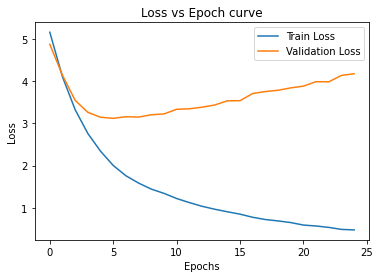

In [43]:
train_test_metrics_graph(train_loss_all, valid_loss_all)

In [30]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.085 | Test PPL:  21.876 |


### Inference


Inference
Now we can use our trained model to generate translations.

Note: these translations will be poor compared to examples shown in paper as they use hidden dimension sizes of 1000 and train for 4 days! They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our translate_sentence will do the following:

* ensure our model is in evaluation mode, which it should always be for inference
* tokenize the source sentence if it has not been tokenized (is a string)
* numericalize the source sentence
* convert it to a tensor and add a batch dimension
* get the length of the source sentence and convert to a tensor
* feed the source sentence into the encoder
* create the mask for the source sentence
* create a list to hold the output sentence, initialized with an <sos> token
* create a tensor to hold the attention values
* while we have not hit a maximum length
    * get the input tensor, which should be either <sos> or the last predicted token
    * feed the input, all encoder outputs, hidden state and mask into the decoder
    * store attention values
    * get the predicted next token
    * add prediction to current output sentence prediction
    * break if the prediction was an <eos> token
* convert the output sentence from indexes to tokens
* return the output sentence (with the <sos> token removed) and the attention values over the sequence

In [31]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()
    # If sentence is a string, tokenise the string. Else, if a list 
    if isinstance(sentence, str):
        tokens = [token.lower() for token in tokenize_en(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    # Add start of sentence and end of sentence to the tokens
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    # Numericalize the source sentence
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    # src_indexes shape = [src_len]

    # Convert to tensor and add batch dimension.
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # src_tensor shape = [src_len, batch_size]
    # print("Is model on cuda?", next(model.parameters()).is_cuda)
    # print("Is source tensor on cuda?",src_tensor.is_cuda)

    # get the length of the source sentence and convert to a tensor
    src_len = torch.LongTensor([len(src_indexes)]).cpu()

    # Feed source sentence into encoder
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)
    
    # create the mask for the source sentence
    mask = model.create_mask(src_tensor)
    
    # create a list to hold the output sentence, initialized with an <sos> token
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    # create a tensor to hold the attention values
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [32]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

### Inference on train example

In [33]:
example_idx = 5

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['a', 'man', 'in', 'green', 'holds', 'a', 'guitar', 'while', 'the', 'other', 'man', 'observes', 'his', 'shirt', '.']
trg = ['ein', 'mann', 'in', 'grün', 'hält', 'eine', 'gitarre', ',', 'während', 'der', 'andere', 'mann', 'sein', 'hemd', 'ansieht', '.']


In [34]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['ein', 'mann', 'in', 'grün', 'hält', 'eine', 'gitarre', ',', 'während', 'ein', 'mann', 'beobachtet', 'sein', 'hemd', 'ansieht', '.', '<EOS>']


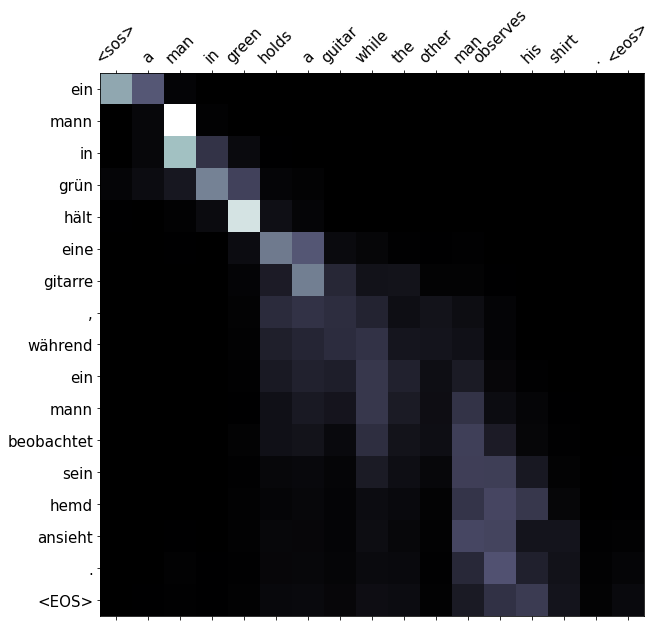

In [35]:
display_attention(src, translation, attention)

### Inference on Validation example

In [36]:
example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']
trg = ['eine', 'frau', 'spielt', 'ein', 'lied', 'auf', 'ihrer', 'geige', '.']


predicted trg = ['eine', 'frau', 'spielt', 'trommel', 'auf', 'ihrer', 'geige', '.', '<EOS>']


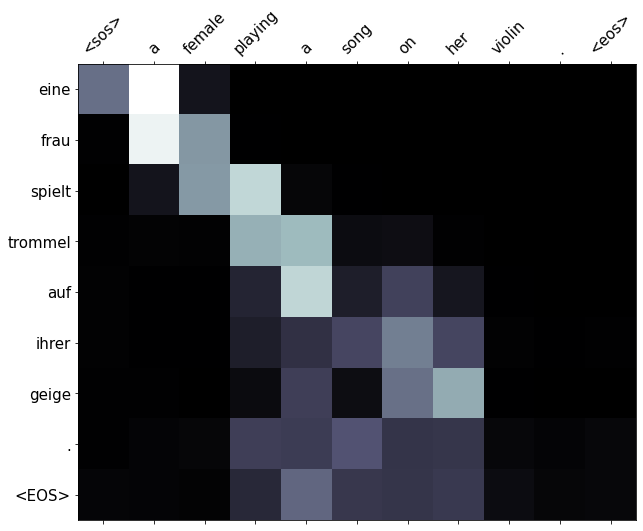

In [37]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

### Inference on test example

In [38]:
example_idx = 18

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'mountain', 'climbing', '.']
trg = ['die', 'person', 'im', 'gestreiften', 'shirt', 'klettert', 'auf', 'einen', 'berg', '.']


predicted trg = ['die', 'person', 'in', 'gestreiftem', 'hemd', 'klettert', 'auf', 'dem', 'hügel', '.', '<EOS>']


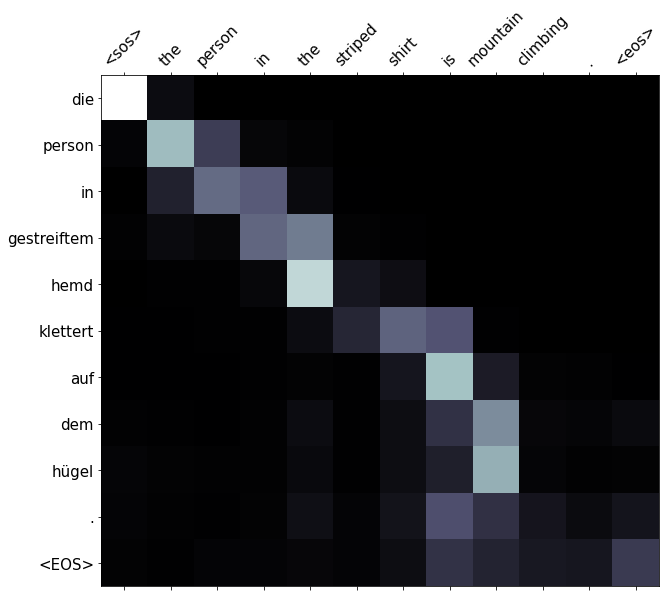

In [39]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

### BLEU score

In [40]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [41]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 27.18
